# Tutorial 2: Testing for Normality and Time Series Basics

In [2]:
import numpy as np
import pandas as pd
from scipy.special import kolmogorov
from scipy.stats import kstest, norm, chi2, jarque_bera, ecdf
import matplotlib.pyplot as plt
import os

In [3]:
def plot_kolmogorov_dist(start, end, delta):
    x = np.arange(start, end, delta)
    # kolmogorov() returns the survival function
    cdf = pd.Series(1 - kolmogorov(x), index=x) 
    pdf = cdf.diff() / delta

    pdf.plot(label='pdf')
    cdf.plot(label='cdf')
    plt.title(f'Kolmogorov Distribution on [{start}, {end}]')
    plt.legend()
    plt.show()


def plot_chi2_dist(start, end, delta, df, plot_cdf=True, dist_name=None, **kwargs):
    x = np.arange(start, end, delta)
    dist = chi2(df=df)
    pdf = pd.Series(dist.pdf(x), index=x)
    cdf = pd.Series(dist.cdf(x), index=x)

    pdf.plot(label='pdf')
    if plot_cdf:
        cdf.plot(label='cdf')

    if dist_name is None:
        dist_name = rf'$\chi_{df}^2$'
    plt.title(rf'{dist_name} Distribution on [{start:.2f}, {end:.2f}]')
    plt.legend()
    plt.show()


def distribution_test(x, test_func, dist_name, alpha=0.05, **kwargs):
    test_result = test_func(x, **kwargs)
    test_name = test_func.__name__
    
    assert 'pvalue' in test_result.__dir__()
    pvalue = test_result.pvalue
    
    is_rejected = pvalue < alpha
    is_rejected = "DO" if is_rejected else "DO NOT"
    print(f"{test_name} p-value={pvalue:.4f}, so we {is_rejected} reject H_0 that X follows {dist_name} distribution at level {alpha}.")
    return test_result
    

def mahalanobis_distance(X: np.ndarray):
    assert isinstance(X, np.ndarray)
    n, p = X.shape
    mu = np.mean(X, axis=0)
    S = np.cov(X, rowvar=False)
    X0 = X - mu
    d2 = np.diag(X0 @ np.linalg.solve(S, X0.T))
    return np.sqrt(d2)


def plot_against_theo(x, theo_dist, title='QQ Plot', **kwargs):
    empirical_cdf = ecdf(x).cdf
    e_q, e_prob = empirical_cdf.quantiles, empirical_cdf.probabilities
    theo_q = theo_dist.ppf(e_prob)

    plt.figure(**kwargs)
    plt.title(title)
    plt.scatter(theo_q, e_q, s=5)
    plt.xlabel('theoretical')
    plt.ylabel('empirical')
    plt.plot(theo_q, theo_q, linestyle='--', color='r')
    plt.plot()
    plt.show()


def chisq_qq_plot(X: np.array, **kwargs):
    """
    A visualization function that helps check normality on multivariate data.
    """
    n, p = X.shape
    d2 = mahalanobis_distance(X) ** 2
    theo_dist = chi2(df=p)
    title=f'Chi Squared QQ Plot, dimension={p}'
    plot_against_theo(d2, theo_dist, title=title, **kwargs)


def simulate_multi_normal(n, p, rng=None):
    if rng is None:
        rng = np.random.default_rng()
        
    mu = rng.normal(size=p)
    C = rng.normal(size=(p, p))
    S = C.T @ C
    C2 = np.linalg.cholesky(S)
    
    Z = rng.normal(size=(n, p))
    X = Z @ C + mu
    return X

In [4]:
rng = np.random.default_rng(12345)

## 1. Normality Test

Financial Time Series are known to be fat-tailed. To rigorously test against the normality assumption, we can use the following statistical tests:


1. Kolmogorov–Smirnov (KS) test
2. Jarque-Bera (JB) test
3. Mahalanobis Distance

### 1.1. (One-sample) KS test

Given $n$ i.i.d. random variables $X_{1:n}$, let $\hat F_n(x) = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}[X_i \le x]$ be the empirical CDF, and $F(x)$ be the theorectial CDF.

Then, the **KS Statistics** $D_n(x) := \sup_{x \in \mathbb R} |F(x) - \hat F_n(x)|$

If $F$ is continuous, then under the null hypothesis, $\sqrt{n} D_n \xrightarrow{d} K$, where $K$ is the Kolmogorov distribution.

and $ K := \sup_{t \in [0, 1]} |B(t)|$, with $B(t)$ being a Brownian Bridge over $[0, 1]$. (this line is optional and won't be tested)

Therefore, we reject the null hypothesis that $X \sim F$ at level $\alpha$ if:

$\sqrt{n} D_n > K(\alpha)$, where $K(\alpha)$ satisfies $P(K \le K(\alpha)) = 1 - \alpha$

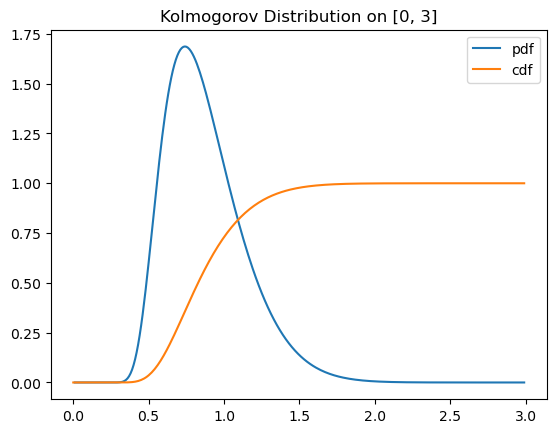

In [10]:
start, end, delta = 0, 3, 0.01
plot_kolmogorov_dist(start, end, delta)

In [11]:
theo_dist = norm
x = theo_dist.rvs(size=1000, random_state=rng)

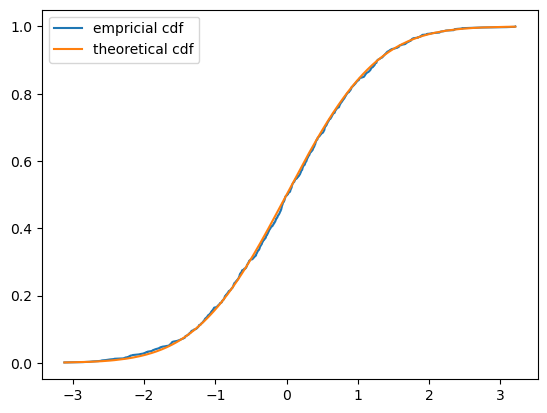

In [12]:
empirical_cdf = ecdf(x).cdf
q, p = empirical_cdf.quantiles, empirical_cdf.probabilities

plt.plot(q, p, label='empricial cdf')
plt.plot(q, theo_dist.cdf(q), label='theoretical cdf')
plt.legend()
plt.show()

Essentially, KS-Stat compute the maximum absolute difference of the two curves.

In [14]:
alpha = 0.05
ks_test = distribution_test(x, test_func=kstest, dist_name='normal', cdf=theo_dist.cdf, alpha=alpha)

kstest p-value=0.8948, so we DO NOT reject H_0 that X follows normal distribution at level 0.05.


### 1.2 Jarque-Bera Test

JB test is based on two quantities:

1. Sample Skewness $S = \frac{\hat \mu_3}{\hat \sigma^3} = [\frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^3] / [\frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^2]^{3/2}$
2. Sample Kurtosis $K = \frac{\hat \mu_4}{\hat \sigma^4} = [\frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^4] / [\frac{1}{n} \sum_{i=1}^n (x_i - \bar x)^2]^{2}$

where $\hat \mu_3, \hat \mu_4$ are the $3^{rd}, 4^{th}$ sample central moments, and $\hat \sigma$ is the sample standard deviations.

The **JB Statistics** is defined as $JB_n = \frac{n}{6} [S^2 + \frac{1}{4}(K-3)^2]$

Our $H_0$ is $S=0$ and $K=3$. If $X_i$ come from the normal distribution, $JB_n \sim \chi_2^2$ as $n \to \infty$.

Therefore, we reject $H_0$ when $JB_n > \chi_2^2(a)$, where $\chi_2^2(\alpha)$ satisfies $P(\chi_2^2 \le \chi_2^2(\alpha)) = 1 - \alpha$

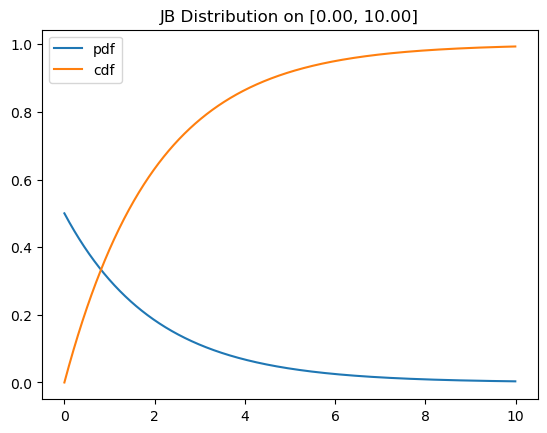

In [18]:
start, end, delta = 0, 10, 0.01
plot_chi2_dist(start, end, delta, df=2, dist_name='JB', figsize=(8, 5))

In [19]:
jb_test = distribution_test(x, test_func=jarque_bera, dist_name='normal', alpha=alpha)

jarque_bera p-value=0.8200, so we DO NOT reject H_0 that X follows normal distribution at level 0.05.


### 1.3 Mahalanobis Distance

If $\mathbf{X}_i \sim N_p(\mathbf{\mu_p}, \mathbf{\Sigma_{p \times p}})$, then:

$d_i^2 = (\mathbf x_i - \mathbf{\bar x})^T \mathbf S^{-1} (\mathbf x_i - \mathbf{\bar x}) \sim \chi^2_p$,

where $\mathbf{\bar x}, \mathbf S$ are the sample mean and covariance matrix.

Moreover, we can use $d_i^2$ to **detect outliers** using the chisq-QQ-plot.

In [22]:
n, p = 1000, 4
X = simulate_multi_normal(n, p, rng=rng)

In the above, we simulate $X_{1:1000} \sim N_4(\mathbf{\mu_4}, \mathbf{S_{4 \times 4}})$, using a random $(\mathbf{\mu_4}, \mathbf{S_{4 \times 4}})$

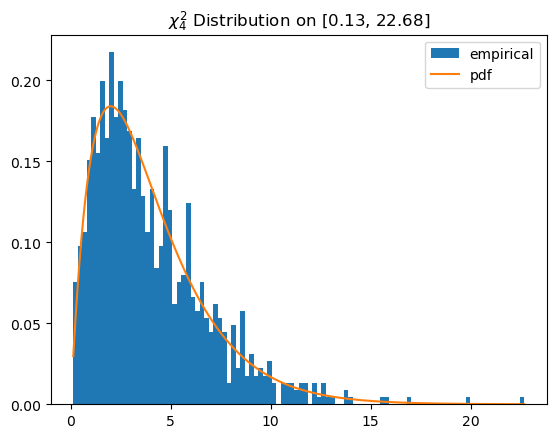

In [24]:
d = mahalanobis_distance(X)
plt.hist(d ** 2, bins=100, density=True, label='empirical');
start, end, delta = (d ** 2).min(), (d ** 2).max(), delta
plot_chi2_dist(start, end, delta, df=p, plot_cdf=False, figsize=(8, 5));

As we can see, $d_i^2$ indeed follows $\chi_p^2$ in this simulation.

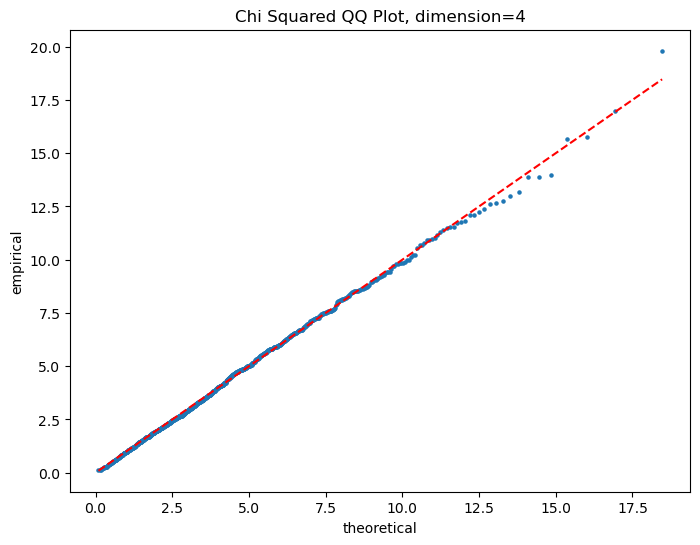

In [26]:
chisq_qq_plot(X, figsize=(8, 6))

## 2. Normality Test on Financial Data

In [28]:
FDA_DIR = os.path.join(os.getcwd(), os.pardir, r'PycharmProjects/Financial-Data-Analytics')
DATA_DIR = rf'{FDA_DIR}/Datasets'

def read_file(filename, dir=None, static=False, **kwargs):
    if dir is None:
        dir = DATA_DIR
        
    path = os.path.join(dir, filename)
    extension = filename.rsplit('.', 1)[-1]

    if extension == 'csv':
        return pd.read_csv(path, **kwargs)
    elif extension in ['parq', 'parquet']:
        return pd.read_parquet(path, **kwargs)
    elif extension == 'json':
        with open(path, 'r') as file:
            return json.load(file)
    elif extension == 'xlsx':
        return pd.read_excel(path, **kwargs)
    else:
        raise NotImplementedError

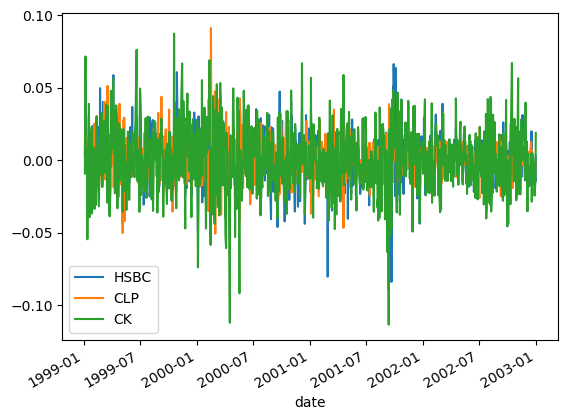

In [29]:
px = read_file('HSI/stock_1999_2002.csv', index_col=0) # means we set column 0 as the index
px = px.rename_axis('date')
px.index = pd.to_datetime(px.index, format='%d/%m/%Y')
rets = np.log(px).diff().dropna(how='any')
rets.plot();

rets_norm = (rets - rets.mean()) / rets.std()

HSBC:


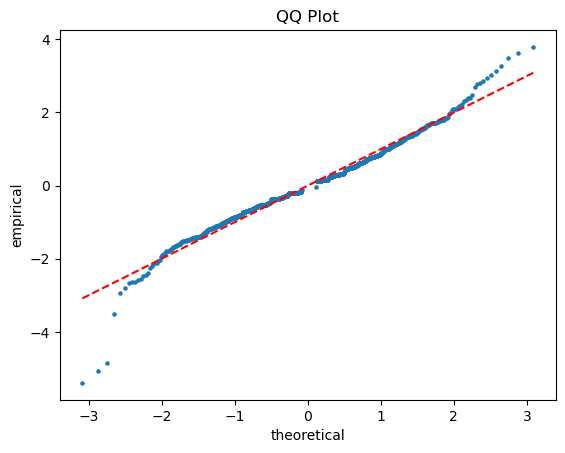

kstest p-value=0.0000, so we DO reject H_0 that X follows normal distribution at level 0.05.
jarque_bera p-value=0.0000, so we DO reject H_0 that X follows normal distribution at level 0.05.


CLP:


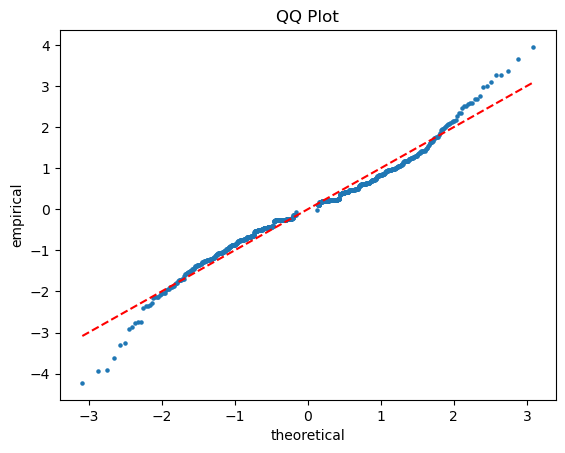

kstest p-value=0.0000, so we DO reject H_0 that X follows normal distribution at level 0.05.
jarque_bera p-value=0.0000, so we DO reject H_0 that X follows normal distribution at level 0.05.


CK:


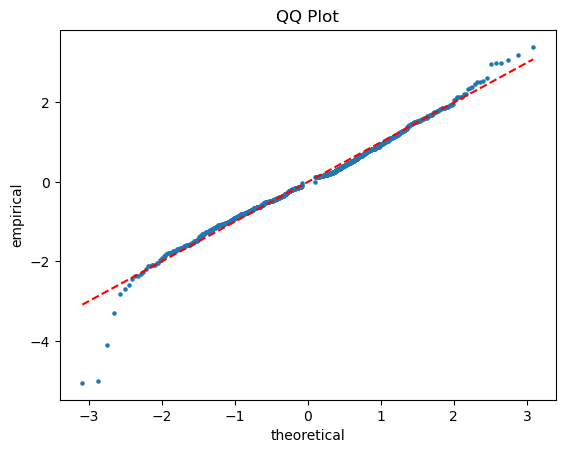

kstest p-value=0.0000, so we DO reject H_0 that X follows normal distribution at level 0.05.
jarque_bera p-value=0.0000, so we DO reject H_0 that X follows normal distribution at level 0.05.




In [30]:
for sec in rets:
    print(f"{sec}:")
    plot_against_theo(rets_norm[sec].values, theo_dist=norm)
    distribution_test(rets[sec].values, test_func=kstest, dist_name='normal', cdf=theo_dist.cdf, alpha=alpha)
    distribution_test(rets[sec].values, test_func=jarque_bera, dist_name='normal', alpha=alpha)
    print('\n')

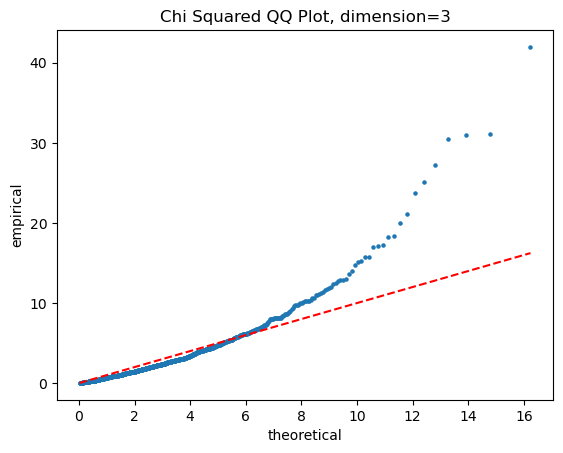

In [31]:
chisq_qq_plot(rets.values)

# 3. Conclusion

Now we can rigorously see that financial time series are not normally distributed, to recap:

We can conduct normality tests on 1-D data using the following functions:

1. ```scipy.stats.kstest``` 
2. ```scipy.stats.jarque_bera```


For eye-ball diagnostics:

1. ```scipy.stats.ecdf```
2. ```chisq_qq_plot``` that we wrote ourselves, this tells us whether the data are **multivariate normal**